<a href="https://colab.research.google.com/github/Kafleavinash/Machinelearning_soil/blob/main/CNN_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks for Image Classification

Goals of the lecture:
1. Get to know the UC Merced Land Use Dataset
2. Understand the difference between single-label classification (SLC) and multi-label classification (MLC)
3. Learn about image transformations in the training pipeline
4. Train a predefined ResNet18 model
5. Understand and make use of Transfer Learning

This practical lecture utilizes [UC Merced Land Use Dataset](http://weegee.vision.ucmerced.edu/datasets/landuse.html) for CNN based single-label classification.

UC Merced Land Use Dataset contains 2100 RGB aerial images with a size of
256 × 256 pixels and a spatial resolution of 0.3 m. The single-label version of the dataset consists of 21 land use classes, including: agricultural, airplane, baseballdiamond, beach, buildings, chaparral, denseresidential, forest, freeway, golfcourse, harbor, intersection, mediumresidential, mobilehomepark, overpass, parkinglot, river, runway, sparseresidential, storagetanks, tenniscourt.

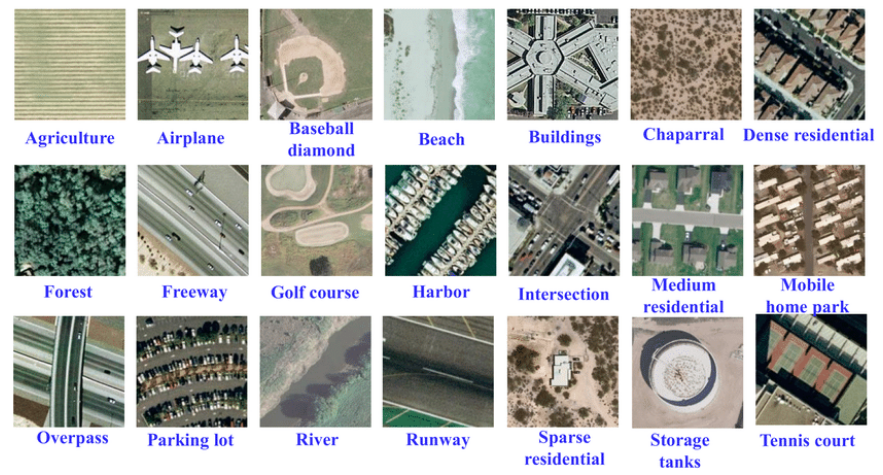

## Import Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import requests
from tqdm.notebook import tqdm
from pathlib import Path


def download_file_with_progress(url: str, output_file: Path):
    """
    Given a `url` as a String and an `output_file` as a file-path the item will
    be downloaded and written to the `output_file`. If the `output_file` already
    exists, it will be overwritten.
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    chunk_size = 2**20  # mb

    with open(output_file, "wb") as f:
        for data in tqdm(
            response.iter_content(chunk_size=chunk_size),
            total=total_size // chunk_size,
            unit="MB",
            unit_scale=True,
            desc="Downloading",
        ):
            f.write(data)

In [ ]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)
# For quick prototyping there is on such things as _too many_ asserts!
assert data_path.exists, "Should exist after calling mkdir!"

## Define Dataset in PyTorch and Download Data

In [ ]:
import zipfile
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset


class UCMerced(Dataset):
    def __init__(self, base_dir: Path, img_transform: transforms = None):
        self.base_dir = base_dir
        self.download_dataset()
        self.images_path = base_dir / "UCMerced_LandUse/Images"
        self.class_names = sorted(
            [cl.name for cl in self.images_path.iterdir() if not cl.name.startswith(".")]
        )
        self.img_paths, self.targets = self.read_data()
        self.img_transform = img_transform

    def download_dataset(self):
        ucmerced_path = self.base_dir / "UCMerced.zip"
        if not ucmerced_path.exists():
            print("Downloading UCMerced")
            download_file_with_progress(
                "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip",
                ucmerced_path,
            )
            zipf = zipfile.ZipFile(ucmerced_path)
            zipf.extractall(self.base_dir)

    def read_data(self):
        img_paths, targets = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = self.images_path / cl_name

            for img_path in sorted(cl_path.iterdir()):
                img_paths.append(img_path)
                targets.append(cl_id)

        return img_paths, targets

    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        target = self.targets[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return len(self.img_paths)

In [ ]:
full_dataset = UCMerced(data_path)

Downloading:   0%|          | 0.00/317 [00:00<?, ?MB/s]

In [ ]:
print("\n".join(full_dataset.class_names))

agricultural
airplane
baseballdiamond
beach
buildings
chaparral
denseresidential
forest
freeway
golfcourse
harbor
intersection
mediumresidential
mobilehomepark
overpass
parkinglot
river
runway
sparseresidential
storagetanks
tenniscourt


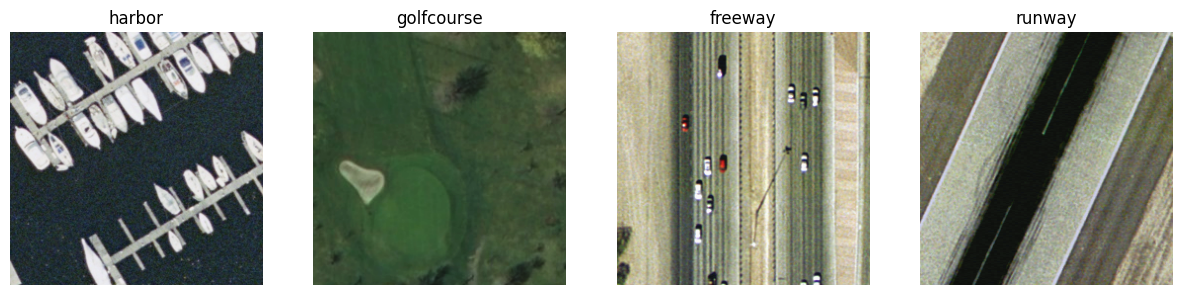

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes = axes.flatten()

for i in range(4):
    idx = np.random.randint(low=0, high=2100)
    img, label = full_dataset[idx]
    axes[i].imshow(img)
    axes[i].set_title(full_dataset.class_names[label])
    axes[i].axis('off')

## Define Customized PyTorch Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN2D(nn.Module):
    def __init__(self, num_channels: int, input_shape: tuple, num_classes: int, num_filter: int = 2):
        super(CNN2D, self).__init__()
        self.num_channels = num_channels
        self.num_filter = num_filter
        self.input_shape = input_shape

        self.conv1 = nn.Conv2d(num_channels, num_filter, kernel_size=(7, 7), stride=2, padding=3)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(num_filter, 2 * num_filter, kernel_size=(3, 3), padding=1)
        self.pool2 = nn.MaxPool2d((2, 2))
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)

    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, self.num_channels, self.input_shape[0], self.input_shape[1]))
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
            x = self.pool2(x)
            b, c, w, h = x.size()
        return b * c * w * h

In [ ]:
cnn2d = CNN2D(num_channels=3, input_shape=(64, 64), num_classes=21, num_filter=10)

In [ ]:
from torchinfo import summary

summary(cnn2d, input_size=(3, 64, 64), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN2D                                    [3, 64, 64]               [1, 21]                   --
├─Conv2d: 1-1                            [3, 64, 64]               [10, 32, 32]              1,480
├─MaxPool2d: 1-2                         [10, 32, 32]              [10, 16, 16]              --
├─Conv2d: 1-3                            [10, 16, 16]              [20, 16, 16]              1,820
├─MaxPool2d: 1-4                         [20, 16, 16]              [20, 8, 8]                --
├─Linear: 1-5                            [1, 1280]                 [1, 21]                   26,901
Total params: 30,201
Trainable params: 30,201
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.08
Input size (MB): 0.05
Forward/backward pass size (MB): 0.12
Params size (MB): 0.12
Estimated Total Size (MB): 0.29

In [ ]:
!pip install torchinfo

Convolutional Layer Output size: $\frac{N-F + 2P}{S}+1$

Pooling Layer Output size: $\frac{N - F}{S} + 1$

# Define Training Hyperparameter

In [ ]:
def get_device(cuda_no):
    return torch.device('cpu') if cuda_no < 0 or not torch.cuda.is_available() else torch.device(cuda_no)

In [ ]:
# fmt: off
device         = get_device(0)
batch_size     = 64
learning_rate  = 0.01
epochs         = 10
# fmt: on

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn2d.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=0.00005,
    nesterov=True,
)

# Transformations

Transformations are usually applied to the images as part of the data loading process to improve the training process. They usually include:
- transforming numpy arrays or PIL images to PyTorch tensors
- normalizing the data per channel by mean 0 and standard deviation of 1
- data augmentation techniques

In [ ]:
?transforms.ToTensor

In [ ]:
?transforms.Normalize

In [ ]:
# mean+std precomputed on whole dataset
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]

tr_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

te_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

### Example of ColorJitter Data Augmentation

<img src="https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_illustrations_012.png" align="center" alt="Drawing" style="width: 900px;height:200px"/>

Source: https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_illustrations_012.png

### Example of RandomResizeCrop Data Augmentation

<img src="https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_illustrations_010.png" align="center" alt="Drawing" style="width: 900px;height:200px"/>

Source: https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_illustrations_010.png

# Create Split and Set-Up DataLoader

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
?train_test_split

In [ ]:
def get_split_idx(targets: np.array, train_size: float, val_size: float, test_size: float):
    assert train_size + val_size + test_size == 1
    relative_val_size = val_size / (1 - test_size)
    full_idx = np.arange(0, len(targets))
    train_val_idx, test_idx, y_trainval, y_test = train_test_split(
        full_idx, targets, test_size=test_size, stratify=targets
    )
    train_idx, val_idx, y_train, y_val = train_test_split(
        train_val_idx, y_trainval, test_size=relative_val_size, stratify=y_trainval
    )
    return train_idx, val_idx, test_idx

In [ ]:
# compute train, val & test set idx
train_size = 0.5
val_size   = 0.2
test_size  = 0.3
train_idx, val_idx, test_idx = get_split_idx(full_dataset.targets, train_size, val_size, test_size)

In [ ]:
print(f"train_len: {len(train_idx):>4} ({len(train_idx)/len(full_dataset.targets)*100:.2f}%)")
print(f"  val_len: {len(val_idx):>4} ({len(val_idx)/len(full_dataset.targets)*100:.2f}%)")
print(f" test_len: {len(test_idx):>4} ({len(test_idx)/len(full_dataset.targets)*100:.2f}%)")

train_len: 1049 (49.95%)
  val_len:  421 (20.05%)
 test_len:  630 (30.00%)


In [ ]:
# instatiate one full dataset with train transformation and one with test transformation
full_dataset_tr = UCMerced(data_path, img_transform=tr_transform)
full_dataset_te = UCMerced(data_path, img_transform=te_transform)

## Image Transformations

In [ ]:
# Image transformations

In [ ]:
from torch.utils.data import Subset, DataLoader

train_dataset = Subset(full_dataset_tr, train_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Subset(full_dataset_te, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = Subset(full_dataset_te, test_idx)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
?Subset

# Train the CNN

In [ ]:
import copy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
def train(
    model: nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss,
    train_loader: DataLoader,
    epochs: int,
    device: torch.device,
    val_loader: DataLoader = None,
):
    """
    Training loop to optimize a network for several epochs and a specified loss.

    Args:
    -----
    model               : a PyTorch model
    optimizer           : a PyTorch optimizer
    criterion           : a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
    train_loader        : a PyTorch trainset loader
    epochs              : int specifying the number of training epochs
    device              : torch device to use (defaults to CPU)
    val_loader (opt.)   : validation dataset
    """
    model.to(device)  # put model on device
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_model = copy.deepcopy(model)
    best_acc = 0
    best_epoch = 1

    for epoch in tqdm(range(1, epochs + 1), desc="Training the network"):
        model.train()  # set model to training mode
        train_losses_epoch = []
        train_targets = []
        train_preds = []

        # Data-Loading Loop
        with tqdm(train_loader, unit=" batch") as tepoch:
            for idx, (data, targets) in enumerate(tepoch):
                tepoch.set_description("Epoch {}".format(epoch))

                # put loaded data and targets on device
                data, targets = data.to(device), targets.to(device)

                # zero accumulated gradients from previous batch
                optimizer.zero_grad()

                # infer predictions for batch
                output = model(data)
                predictions = output.argmax(dim=1)

                # compute loss from predictions, CELoss automatically applies F.log_softmax
                loss = criterion(output, targets)

                # accumulate gradients for all parameter according to batch errors
                loss.backward()

                # update paramters according to accumulated gradients
                optimizer.step()

                train_losses_epoch.append(loss.item())
                train_targets.append(targets)
                train_preds.append(predictions)

            curr_train_loss = np.mean(train_losses_epoch)
            train_targets = torch.cat(train_targets)
            train_preds = torch.cat(train_preds)

            train_accuracy = accuracy_score(train_targets, train_preds)
            train_losses.append(curr_train_loss)
            train_accuracies.append(train_accuracy)

            print("Train-Loss: {:.2f}. Train-Acc: {:.2f}".format(curr_train_loss, train_accuracy))

        if val_loader is not None:
            model.eval()
            val_losses_epoch = []
            val_targets = []
            val_preds = []

            with torch.no_grad():
                for data, targets in val_loader:
                    # put loaded data and targets on device
                    data = data.to(device)
                    targets = targets.to(device)

                    output = model(data)
                    loss = criterion(output, targets)
                    predictions = output.argmax(dim=1)

                    val_losses_epoch.append(loss.item())
                    val_targets.append(targets)
                    val_preds.append(predictions)

            curr_val_loss = np.mean(val_losses_epoch)
            val_targets = torch.cat(val_targets)
            val_preds = torch.cat(val_preds)

            val_accuracy = accuracy_score(val_targets, val_preds)
            val_losses.append(curr_val_loss)
            val_accuracies.append(val_accuracy)

            # early stopping
            if best_acc < val_accuracy:
                best_acc = val_accuracy
                best_epoch = epoch
                best_model = copy.deepcopy(model)

            if epoch - best_epoch > 10:
                print(f"Early stopping after {epoch} epochs with best epoch in {best_epoch}")
                break

            print("Val-Loss:   {:.2f}. Val-Acc:   {:.2f}".format(curr_val_loss, val_accuracy))

    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train(
    model=cnn2d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=100,  # also test with 100
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 2.98. Train-Acc: 0.08
Val-Loss:   2.80. Val-Acc:   0.15


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 2.61. Train-Acc: 0.22
Val-Loss:   2.45. Val-Acc:   0.22


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 2.14. Train-Acc: 0.35
Val-Loss:   2.26. Val-Acc:   0.34


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 1.70. Train-Acc: 0.50
Val-Loss:   2.37. Val-Acc:   0.35


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 1.28. Train-Acc: 0.62
Val-Loss:   2.41. Val-Acc:   0.31


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 1.02. Train-Acc: 0.71
Val-Loss:   2.13. Val-Acc:   0.44


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.61. Train-Acc: 0.83
Val-Loss:   2.64. Val-Acc:   0.43


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.41. Train-Acc: 0.89
Val-Loss:   2.50. Val-Acc:   0.49


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.31. Train-Acc: 0.91
Val-Loss:   2.57. Val-Acc:   0.49


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.23. Train-Acc: 0.94
Val-Loss:   4.69. Val-Acc:   0.35


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.53. Train-Acc: 0.88
Val-Loss:   2.44. Val-Acc:   0.49


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.20. Train-Acc: 0.95
Val-Loss:   2.93. Val-Acc:   0.49


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.97
Val-Loss:   2.80. Val-Acc:   0.52


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.99
Val-Loss:   3.56. Val-Acc:   0.48


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.12. Train-Acc: 0.98
Val-Loss:   4.92. Val-Acc:   0.46


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.22. Train-Acc: 0.96
Val-Loss:   2.90. Val-Acc:   0.51


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.99
Val-Loss:   3.35. Val-Acc:   0.51


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 1.00
Val-Loss:   3.42. Val-Acc:   0.53


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 1.00
Val-Loss:   3.57. Val-Acc:   0.53


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 1.00
Val-Loss:   3.64. Val-Acc:   0.53


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   3.77. Val-Acc:   0.52


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   3.85. Val-Acc:   0.52


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   3.88. Val-Acc:   0.52


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   3.87. Val-Acc:   0.52


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   3.92. Val-Acc:   0.52


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   3.96. Val-Acc:   0.53


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   4.00. Val-Acc:   0.53


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Val-Loss:   4.02. Val-Acc:   0.52


  0%|          | 0/17 [00:00<?, ? batch/s]

Train-Loss: 0.00. Train-Acc: 1.00
Early stopping after 29 epochs with best epoch in 18


# Test the CNN

In [ ]:
from typing import List

def test(
    model: nn.Module,
    test_loader: DataLoader,
    class_names: List[str],
    device: torch.device,
):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(test_loader, desc="Test: ")):
            # put loaded data and targets on device
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            predicted = output.argmax(dim=1)

            predictions += predicted.tolist()
            targets += target.tolist()

    results = {}

    if class_names is None:
        class_names = range(len(np.unique(targets)))

    cm = confusion_matrix(targets, predictions)

    results["cm"] = cm
    results["overall_acc"] = accuracy_score(targets, predictions)
    results["report"] = classification_report(
        targets,
        predictions,
        target_names=class_names,
        zero_division=0,
        digits=2,
    )

    return results

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
results = test(best_model, test_loader, full_dataset_tr.class_names, device)

Test:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(results["report"])

                   precision    recall  f1-score   support

     agricultural       0.84      0.87      0.85        30
         airplane       0.54      0.50      0.52        30
  baseballdiamond       0.58      0.73      0.65        30
            beach       0.81      0.97      0.88        30
        buildings       0.26      0.17      0.20        30
        chaparral       0.89      0.83      0.86        30
 denseresidential       0.30      0.73      0.43        30
           forest       0.90      0.60      0.72        30
          freeway       0.55      0.53      0.54        30
       golfcourse       0.40      0.47      0.43        30
           harbor       0.89      0.57      0.69        30
     intersection       0.61      0.63      0.62        30
mediumresidential       0.38      0.17      0.23        30
   mobilehomepark       0.64      0.70      0.67        30
         overpass       0.42      0.63      0.51        30
       parkinglot       0.46      0.37      0.41       

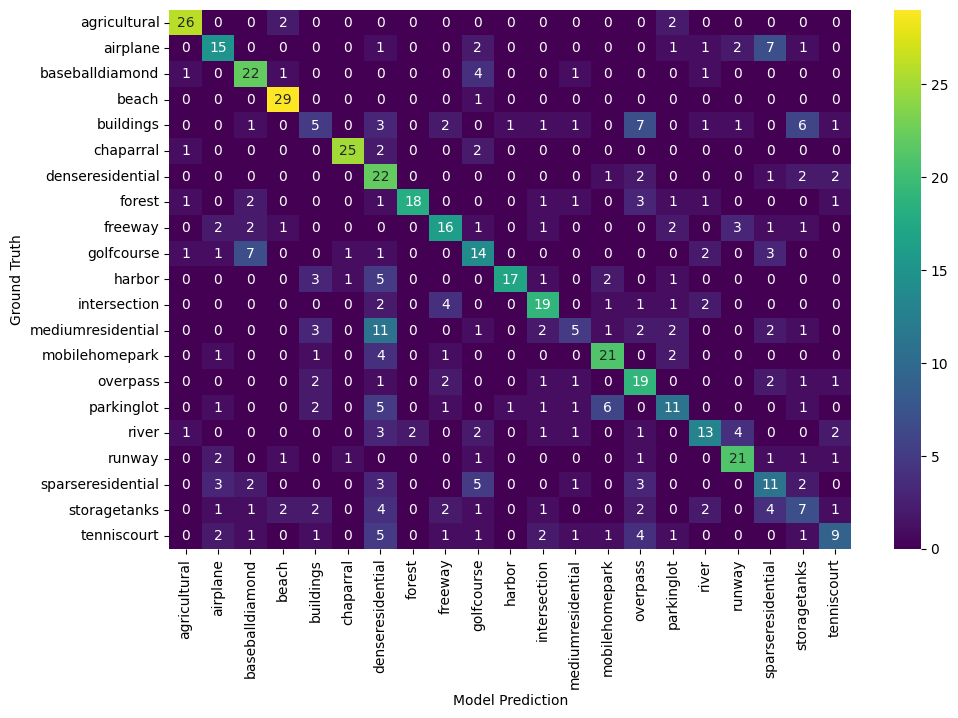

In [ ]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=full_dataset_tr.class_names,
    yticklabels=full_dataset_tr.class_names,
    annot=True
)
ax.set(xlabel="Model Prediction", ylabel="Ground Truth")
plt.show()

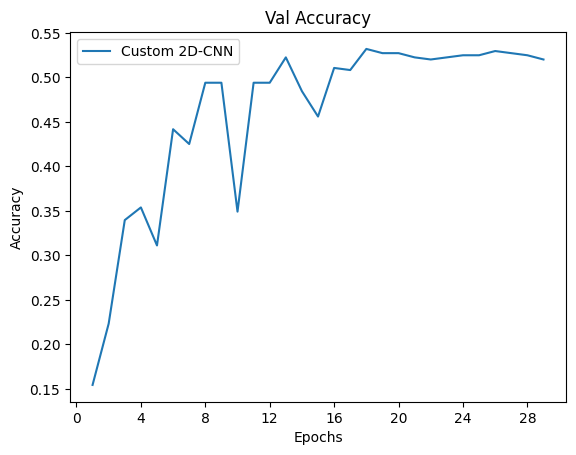

In [ ]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Val Accuracy')
ax.plot(np.arange(1, len(val_accuracies) + 1), val_accuracies, label="Custom 2D-CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

## In-course practice I

In Pytorch, you can use predefined networks (both as pre-trained or training from scratch).

In this practice, try to use predefined `resnet18` model from Pytorch's `torchvision` library. Train it from scratch with the train set and evaluate the new model.

**Hint**: import a `resnet18` from `torchvision.models` and then train it.

for more information check the pytorch documentation:

https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Assuming you want to use ResNet18
resnet_notpretrained = torchvision.models.resnet18(pretrained=False)
# Replace num_classes with the actual number of classes in your dataset
num_ftrs = resnet_notpretrained.fc.in_features
resnet_notpretrained.fc = nn.Linear(num_ftrs, 21) # 21 classes in the UC Merced Land Use Dataset

# Initialize the optimizer
optimizer = optim.Adam(resnet_notpretrained.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# import ...

resnet_notpretrained = ...
optimizer = ...

In [ ]:
best_model2, train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train(
    model=resnet_notpretrained,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Epoch 1: 100%|██████████| 17/17 [00:30<00:00,  1.78s/ batch]


Train-Loss: 2.29. Train-Acc: 0.30


Training the network:  10%|█         | 1/10 [00:34<05:10, 34.49s/it]

Val-Loss:   3.23. Val-Acc:   0.24



Epoch 2: 100%|██████████| 17/17 [00:33<00:00,  1.95s/ batch]


Train-Loss: 1.30. Train-Acc: 0.61


Training the network:  20%|██        | 2/10 [01:11<04:47, 35.97s/it]

Val-Loss:   2.09. Val-Acc:   0.46



Epoch 3: 100%|██████████| 17/17 [00:29<00:00,  1.71s/ batch]


Train-Loss: 0.93. Train-Acc: 0.72


Training the network:  30%|███       | 3/10 [01:44<04:01, 34.51s/it]

Val-Loss:   1.70. Val-Acc:   0.50



Epoch 4: 100%|██████████| 17/17 [00:28<00:00,  1.68s/ batch]


Train-Loss: 0.62. Train-Acc: 0.82


Training the network:  40%|████      | 4/10 [02:17<03:23, 33.94s/it]

Val-Loss:   1.59. Val-Acc:   0.54



Epoch 5: 100%|██████████| 17/17 [00:29<00:00,  1.73s/ batch]


Train-Loss: 0.31. Train-Acc: 0.90


Training the network:  50%|█████     | 5/10 [02:50<02:48, 33.69s/it]

Val-Loss:   1.76. Val-Acc:   0.51



Epoch 6: 100%|██████████| 17/17 [00:29<00:00,  1.71s/ batch]


Train-Loss: 0.26. Train-Acc: 0.93


Training the network:  60%|██████    | 6/10 [03:23<02:13, 33.45s/it]

Val-Loss:   1.92. Val-Acc:   0.50



Epoch 7: 100%|██████████| 17/17 [00:28<00:00,  1.66s/ batch]


Train-Loss: 0.27. Train-Acc: 0.91


Training the network:  70%|███████   | 7/10 [03:56<01:39, 33.22s/it]

Val-Loss:   1.75. Val-Acc:   0.54



Epoch 8: 100%|██████████| 17/17 [00:28<00:00,  1.67s/ batch]


Train-Loss: 0.13. Train-Acc: 0.97


Training the network:  80%|████████  | 8/10 [04:28<01:05, 32.82s/it]

Val-Loss:   1.78. Val-Acc:   0.53



Epoch 9: 100%|██████████| 17/17 [00:28<00:00,  1.67s/ batch]


Train-Loss: 0.11. Train-Acc: 0.96


Training the network:  90%|█████████ | 9/10 [05:01<00:32, 32.86s/it]

Val-Loss:   1.93. Val-Acc:   0.55



Epoch 10: 100%|██████████| 17/17 [00:28<00:00,  1.68s/ batch]


Train-Loss: 0.10. Train-Acc: 0.97


Training the network: 100%|██████████| 10/10 [05:33<00:00, 33.36s/it]

Val-Loss:   2.29. Val-Acc:   0.49


In [ ]:
results2 = test(best_model2, test_loader, full_dataset_tr.class_names, device)

Test: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


In [ ]:
print(results2["report"])

                   precision    recall  f1-score   support

     agricultural       0.77      0.90      0.83        30
         airplane       1.00      0.07      0.12        30
  baseballdiamond       0.90      0.60      0.72        30
            beach       0.51      0.97      0.67        30
        buildings       0.45      0.43      0.44        30
        chaparral       1.00      0.83      0.91        30
 denseresidential       0.45      0.43      0.44        30
           forest       0.62      0.83      0.71        30
          freeway       0.50      0.63      0.56        30
       golfcourse       0.38      0.87      0.53        30
           harbor       0.81      0.97      0.88        30
     intersection       0.73      0.37      0.49        30
mediumresidential       0.56      0.50      0.53        30
   mobilehomepark       0.64      0.70      0.67        30
         overpass       0.42      0.27      0.33        30
       parkinglot       0.71      0.57      0.63       

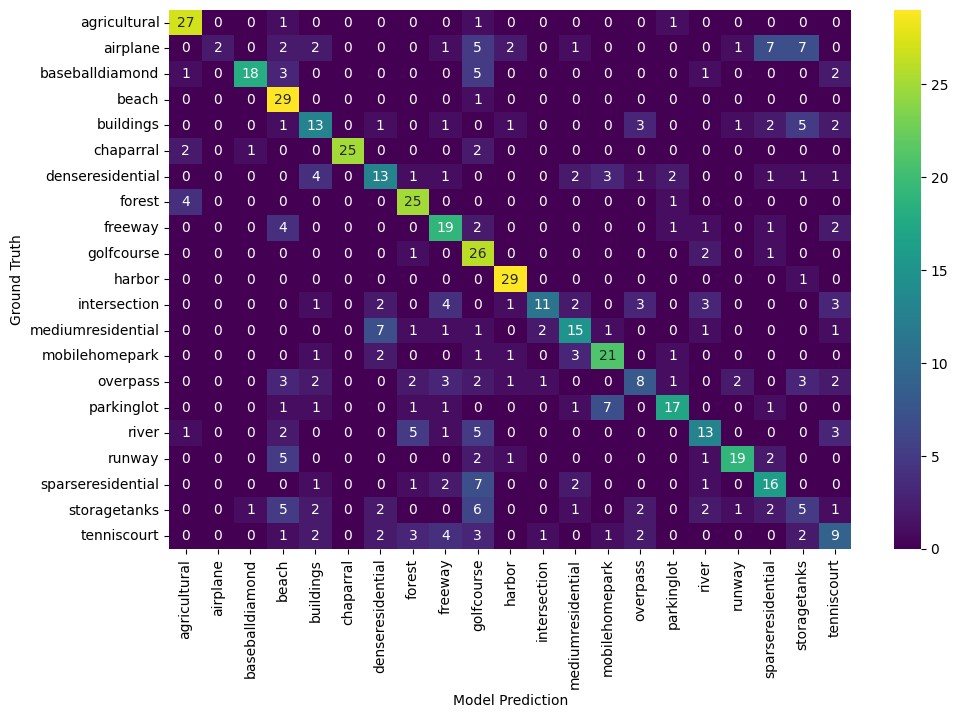

In [ ]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results2["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=full_dataset_tr.class_names,
    yticklabels=full_dataset_tr.class_names,
    annot=True
)
ax.set(xlabel="Model Prediction", ylabel="Ground Truth")
plt.show()

## In-course practice II

When using models that are pretrained on a different, usually bigger dataset (e.g. on the popular Computer Vision dataset ImageNet [1]) for a so-called downstream task in which the pretrained model is fine-tuned on the target dataset, we speak about Transfer Learning.

In this practice, try to use a pretrained version of the predefined `resnet18` model from Pytorch `models` library. You can achieve this by providing pretrained model weights to the weights parameter at initialization of the model. Use the following weights from the `torchvision` library: `torchvision.models.ResNet18_Weights.DEFAULT`. Finetune it on the train set of UCMerced dataset and evaluate the new model.

**Hint**: ImageNet consists of 1000 classes, therefore the last layer of the pretrained model needs to be alternated.

for more information check the pytorch documentation:

https://pytorch.org/docs/stable/torchvision/models.html

[1] https://www.image-net.org/index.php

In [ ]:
# import ...

resnet_notpretrained = ...
optimizer = ...

In [ ]:
best_model3, train_losses3, val_losses3, train_accuracies3, val_accuracies3 = train(
    model=resnet_pretrained,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

In [ ]:
results3 = test(best_model3, test_loader, full_dataset_tr.class_names, device)

In [ ]:
print(results3["report"])

In [ ]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results3["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=full_dataset_tr.class_names,
    yticklabels=full_dataset_tr.class_names,
    annot=True
)
ax.set(xlabel="Model Prediction", ylabel="Ground Truth")
plt.show()

## In-course practice III

Compare the validation accuracy curves of the customized 2D-CNN, the ResNet18 trained from scratch and the pretrained Resnet18.